In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install -Uqq fastai fastbook

from fastai.vision.all import *
from fastbook import *
from fastcore.all import *

path = untar_data(URLs.MNIST_SAMPLE)

In [ ]:
path.ls()

In [ ]:
(path/"train").ls()

In [ ]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

In [ ]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [ ]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[0:27,0:27])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

In [ ]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

In [ ]:
show_image(three_tensors[1]);

In [ ]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

In [ ]:
mean3 = stacked_threes.mean(0)
show_image(mean3);
     

In [ ]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

In [ ]:
a_3 = stacked_threes[1]
show_image(a_3);

In [ ]:
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs,dist_3_sqr

In [ ]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr

In [ ]:
F.l1_loss(a_3.float(),mean7), F.mse_loss(a_3,mean7).sqrt()

In [ ]:
data = [[1,2,3],[4,5,6]]
arr = array (data)
tns = tensor(data)

In [ ]:
arr

In [ ]:
tns

In [ ]:
tns*2
tns.type()

In [ ]:
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shapedef mnist_distance(a,b): return (a-b).abs().mean((-1,-2))
mnist_distance(a_3, mean3)

In [ ]:
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))
mnist_distance(a_3, mean3)

In [ ]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

In [ ]:
def f(x): return x**2
plot_function(f, 'x', 'x**2')

This is the start of the exercise to tune a model using Stochastic Gradient Descent.

In [2]:
# Define a PyTorch which is a series of time every second for 20 seconds starting at 1 second.
time = torch.arange(1.0,21.0)
time

tensor([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19., 20.])

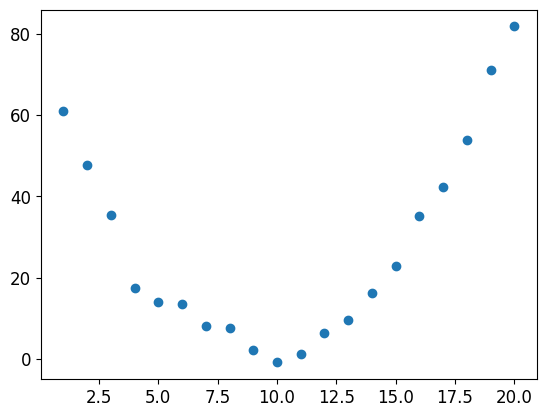

In [3]:
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time,speed);

In [5]:
# We are assuming a quadratic function (i.e., a*x^2 + b*x + c) will be the best fit.
def f(t, params):
    a,b,c = params
    return a*(t**2) + (b*t) + c

In [6]:
# Use mean squared error as the loss function.
def mse(preds, targets): 
    return ((preds-targets)**2).mean()

In [7]:
# Initialize the parameters for the quadratic function (i.e., a, b, and c) with random
# flots and tell PyTorch we want to track their gradients.
params = torch.randn(3).requires_grad_()
params

tensor([-0.7658, -0.7506,  1.3525], requires_grad=True)

In [8]:
# Save the original values for a, b, and c.
orig_params = params.clone()

In [9]:
# Predict the values using the initial set of parameters for a, b, and c.
preds = f(time, params)
preds

tensor([-1.6391e-01, -3.2121e+00, -7.7919e+00, -1.3903e+01, -2.1547e+01, -3.0721e+01, -4.1428e+01, -5.3666e+01, -6.7436e+01, -8.2738e+01, -9.9571e+01, -1.1794e+02, -1.3783e+02, -1.5926e+02,
        -1.8222e+02, -2.0671e+02, -2.3274e+02, -2.6029e+02, -2.8938e+02, -3.2000e+02], grad_fn=<AddBackward0>)

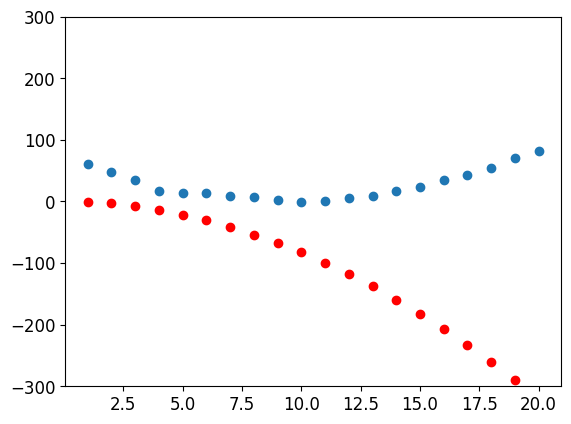

In [10]:
# Visually show the difference between the prediction and the target
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300,300)
show_preds(preds)

In [11]:
loss = mse(preds, speed)
loss

tensor(33737.1953, grad_fn=<MeanBackward0>)

In [12]:
# Calculate by how much the parameters need to change (i.e., gradients)
#: Understanding this bit depends on remembering recent history. To calculate the gradients we call backward on the loss. But this loss was itself calculated by mse, which in turn took preds as an input, which was calculated using f taking as an input params, which was the object on which we originally called requires_grad_—which is the original call that now allows us to call backward on loss. This chain of function calls represents the mathematical composition of functions, which enables PyTorch to use calculus's chain rule under the hood to calculate these gradients.
loss.backward()
params.grad
     

tensor([-69349.5156,  -4228.3770,   -287.5256])

In [20]:
# Update the parameters based on the gradients
lr = 1e-5
params.data -= lr * params.grad.data
params.grad = None
params.data

tensor([-0.0723, -0.7083,  1.3554])

In [21]:
preds = f(time,params)
mse(preds, speed)

tensor(2971.9673, grad_fn=<MeanBackward0>)

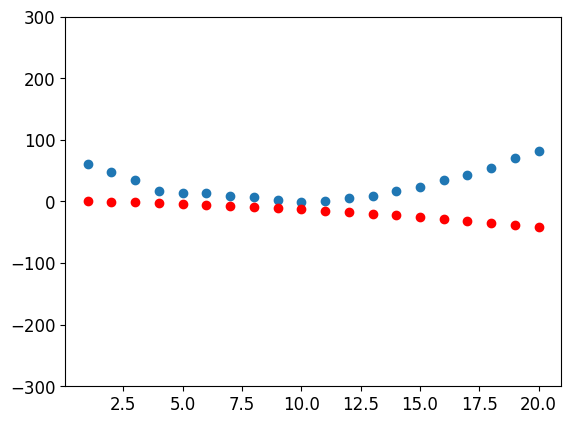

In [22]:
show_preds(preds)

In [23]:

def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds

In [24]:
for i in range(20): apply_step(params)

2971.96728515625
651.590576171875
476.58135986328125
463.38031005859375
462.3831481933594
462.3064880371094
462.2991638183594
462.29718017578125
462.29547119140625
462.29388427734375
462.29217529296875
462.29058837890625
462.2889709472656
462.28729248046875
462.28564453125
462.28399658203125
462.28240966796875
462.28070068359375
462.2791442871094
462.27752685546875


In [26]:
params = orig_params.detach().requires_grad_()

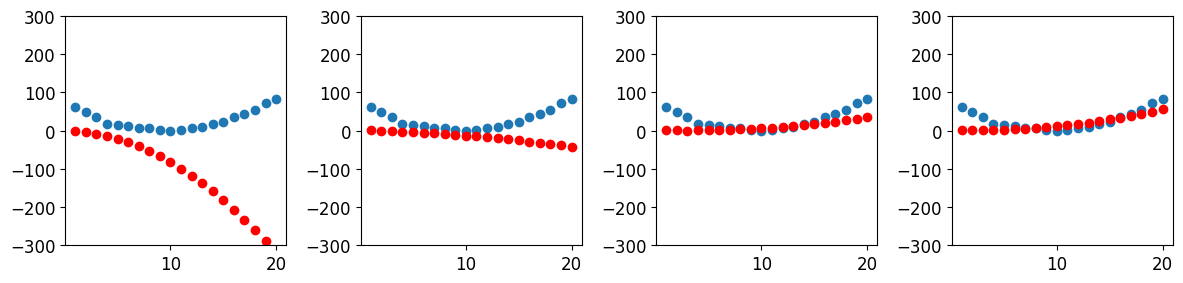

In [27]:
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()